## Vehicle Decteion Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import glob
import time
import cv2
import pickle
import random

%matplotlib inline

## Data collection and exploration

In [2]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape;
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


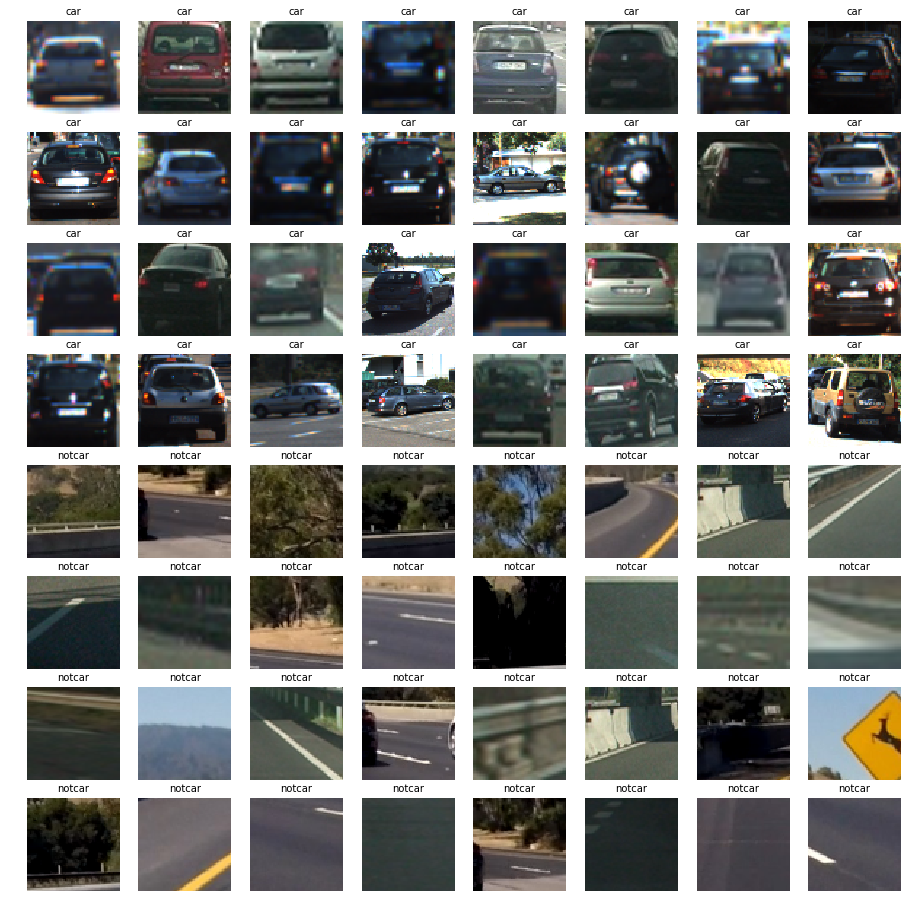

In [3]:
cars = glob.glob('dataset/vehicles/**/*.png')
notcars = glob.glob('dataset/non-vehicles/**/*.png')
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# small dataset for feature selection and classifier test
small_cars = random.sample(cars, 1125)
small_notcars = random.sample(notcars, 1125)


fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(small_cars[np.random.randint(0,len(small_cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(small_notcars[np.random.randint(0,len(small_notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('notcar', fontsize=10)
    axs[i].imshow(img)

## Hog and Color feature function
based on udacity lesson code.

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### HOG feature visualization

/home/wangmin/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


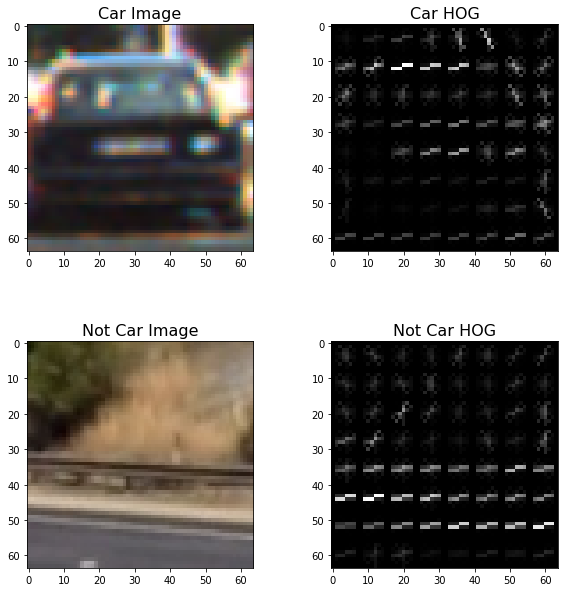

In [6]:
car_img = mpimg.imread(small_cars[5])

_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
notcar_img = mpimg.imread(small_notcars[5])
_, noncar_dst = get_hog_features(notcar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Not Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Not Car HOG', fontsize=16)

## Hog parameter tunning

In [ ]:
# color_spaces = ['YCrCb']
# color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
color_spaces = ['YUV']

orients = [12]
# pix_per_cells = [8]
pix_per_cells = [8]
hog_channels = ["ALL"]
cell_per_blocks = [2]

# hog_channels = [0, 1, 2, "ALL"]
# small_cars = small_cars[:20]
# small_notcars = small_notcars[:20]

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

hist_feats = [True, False]
spatial_feats = [True]

spatial_sizes = [(32, 32), (64, 64), (128, 128)]
hist_bins_list = [16, 32, 64, 128]
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
i = 0;
for color_space in color_spaces:
    for orient in orients:
        for pix_per_cell in pix_per_cells:
            for cell_per_block in cell_per_blocks:
                for hog_channel in hog_channels:
                    for hist_feat in hist_feats:
                        if not hist_feat:
                            continue
                        for spatial_feat in spatial_feats:
                            if not spatial_feat:
                                continue
                            for spatial_size in spatial_sizes:
                                for hist_bins in hist_bins_list:
                                    i = i+1
                                    t=time.time()
                                    car_features = extract_features(small_cars, color_space=color_space, 
                                                            spatial_size=spatial_size, hist_bins=hist_bins, 
                                                            orient=orient, pix_per_cell=pix_per_cell, 
                                                            cell_per_block=cell_per_block, 
                                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                            hist_feat=hist_feat, hog_feat=hog_feat)
                                    notcar_features = extract_features(small_notcars, color_space=color_space, 
                                                            spatial_size=spatial_size, hist_bins=hist_bins, 
                                                            orient=orient, pix_per_cell=pix_per_cell, 
                                                            cell_per_block=cell_per_block, 
                                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                            hist_feat=hist_feat, hog_feat=hog_feat)
                                    t2 = time.time()
                                    # print(color_space,'Color_space',orient,'orientations',pix_per_cell,
                                    #     'pixels per cell and', cell_per_block,'cells per block')

                                    # print('Feature vector length:', len(X_train[0]))

                                    # print(round(t2-t, 2), 'Seconds to Extract Features...')

                                    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                                    # Fit a per-column scaler
                                    X_scaler = StandardScaler().fit(X)
                                    # Apply the scaler to X
                                    scaled_X = X_scaler.transform(X)

                                    # Define the labels vector
                                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

                                    # Split up data into randomized training and test sets
                                    rand_state = np.random.randint(0, 100)
                                    X_train, X_test, y_train, y_test = train_test_split(
                                        scaled_X, y, test_size=0.2, random_state=rand_state)

                                    # Use a linear SVC 
                                    svc = LinearSVC()
                                    # Check the training time for the SVC
                                    t3=time.time()
                                    svc.fit(X_train, y_train)
                                    t4 = time.time()
                                    # print(round(t4-t3, 4), 'Seconds to train SVC...')
                                    # # Check the score of the SVC
                                    # print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
                                    # # Check the prediction time for a single sample

                                    print('| ',i,'\t|',spatial_feat,'\t|',spatial_size,'\t|',
                                          hist_feat,'\t|',hist_bins,'\t|', 
                                        round(t2-t, 2),'\t|Linear SVC  |',round(svc.score(X_test, y_test), 4),'\t|',round(t4-t3, 4))
                #                     print('| ',i,'\t|',color_space,'\t|',orient,'\t|',
                #                           pix_per_cell,'\t|',cell_per_block,'\t|', 
                #                           hog_channel,'\t|', round(t2-t, 2),'\t|Linear SVC  |',round(svc.score(X_test, y_test), 4),'\t|',round(t4-t3, 4))

RGB color space is not good features for hog to detect vehicles
Time cost increases with the orientation numbers
Orientation num of 12 performorms good at aspect of accuracy and time costs

| NO. | Colorspace | Orient | Pixels perCell | Cells per Block | HOG Channel | Extract Time | Classifier | Accuracy | Train Time |
| :--: | :------: | :----: | :----: | :----: | :------: | :--------: | :--------: | :--------: | :--------: |
|  1 	| RGB 	| 9 	| 8 	| 2 	| ALL 	| 8.44 	|Linear SVC  | 0.9511 	| 5.0503
|  2 	| RGB 	| 12 	| 8 	| 2 	| ALL 	| 8.77 	|Linear SVC  | 0.9489 	| 0.8531
|  3 	| RGB 	| 18 	| 8 	| 2 	| ALL 	| 9.69 	|Linear SVC  | 0.9511 	| 0.9631
|  4 	| RGB 	| 36 	| 8 	| 2 	| ALL 	| 11.49 |Linear SVC  | 0.9578 	| 1.4608
|  5 	| HSV 	| 9 	| 8 	| 2 	| ALL 	| 8.74 	|Linear SVC  | 0.9733 	| 0.3411
|  6 	| HSV 	| 12 	| 8 	| 2 	| ALL 	| 8.98 	|Linear SVC  | 0.9822 	| 0.3944
|  7 	| HSV 	| 18 	| 8 	| 2 	| ALL 	| 9.72 	|Linear SVC  | 0.9778 	| 0.6515
|  8 	| HSV 	| 36 	| 8 	| 2 	| ALL 	| 11.87 |Linear SVC  | 0.9822 	| 1.1518
|  9 	| LUV 	| 9 	| 8 	| 2 	| ALL 	| 9.15 	|Linear SVC  | 0.9578 	| 5.7852
|  10 	| LUV 	| 12 	| 8 	| 2 	| ALL 	| 9.46 	|Linear SVC  | 0.9756 	| 0.4846
|  11 	| LUV 	| 18 	| 8 	| 2 	| ALL 	| 10.01 |Linear SVC  | 0.9711 	| 0.6345
|  12 	| LUV 	| 36 	| 8 	| 2 	| ALL 	| 12.07 |Linear SVC  | 0.9867 	| 1.1297
|  13 	| HLS 	| 9 	| 8 	| 2 	| ALL 	| 8.66 	|Linear SVC  | 0.9778 	| 0.3291
|  14 	| HLS 	| 12 	| 8 	| 2 	| ALL 	| 9.02 	|Linear SVC  | 0.98 	| 0.4273
|  15 	| HLS 	| 18 	| 8 	| 2 	| ALL 	| 9.8 	|Linear SVC  | 0.9756 	| 0.602
|  16 	| HLS 	| 36 	| 8 	| 2 	| ALL 	| 11.91 |Linear SVC  | 0.9778 	| 1.1222
|  17 	| YUV 	| 9 	| 8 	| 2 	| ALL 	| 8.59 	|Linear SVC  | 0.9733 	| 0.3299
|  18 	| YUV 	| 12 	| 8 	| 2 	| ALL 	| 8.93 	|Linear SVC  | 0.9867 	| 0.4075
|  19 	| YUV 	| 18 	| 8 	| 2 	| ALL 	| 9.64 	|Linear SVC  | 0.9778 	| 0.5656
|  20 	| YUV 	| 36 	| 8 	| 2 	| ALL 	| 11.77 |Linear SVC  | 0.9867 	| 1.1095
|  21 	| YCrCb | 9 	| 8 	| 2 	| ALL 	| 8.64 	|Linear SVC  | 0.9756 	| 0.3924
|  22 	| YCrCb | 12 	| 8 	| 2 	| ALL 	| 8.93 	|Linear SVC  | 0.9667 	| 0.3848
|  23 	| YCrCb | 18 	| 8 	| 2 	| ALL 	| 9.66 	|Linear SVC  | 0.9756 	| 0.5941
|  24 	| YCrCb | 36 	| 8 	| 2 	| ALL 	| 11.78 |Linear SVC  | 0.98 	| 1.2059

YUV performance the best in all vehicles and not vehicels data

| NO. | Colorspace | Orient | Pixels perCell | Cells per Block | HOG Channel | Extract Time | Classifier | Accuracy | Train Time |
| :--: | :------: | :----: | :----: | :----: | :------: | :--------: | :--------: | :--------: | :--------: |
|  1 	| RGB 	| 12 	| 8 	| 2 	| ALL 	| 76.16 	|Linear SVC  | 0.9727 	| 30.9131
|  2 	| HSV 	| 12 	| 8 	| 2 	| ALL 	| 78.38 	|Linear SVC  | 0.9828 	| 4.8821
|  3 	| LUV 	| 12 	| 8 	| 2 	| ALL 	| 90.82 	|Linear SVC  | 0.9735 	| 31.413
|  4 	| HLS 	| 12 	| 8 	| 2 	| ALL 	| 77.9 	|Linear SVC  | 0.9831 	| 28.569
|  5 	| YUV 	| 12 	| 8 	| 2 	| ALL 	| 79.44 	|Linear SVC  | 0.9862 	| 5.4692
|  6 	| YCrCb 	| 12 	| 8 	| 2 	| ALL 	| 73.53 	|Linear SVC  | 0.98 	| 19.823

ALL HOG channel performance the best

| NO. | Colorspace | Orient | Pixels perCell | Cells per Block | HOG Channel | Extract Time | Classifier | Accuracy | Train Time |
| :--: | :------: | :----: | :----: | :----: | :------: | :--------: | :--------: | :--------: | :--------: |
|  1 	| YUV 	| 12 	| 8 	| 2 	| 0 	| 4.73 	|Linear SVC  | 0.9467 	| 2.3603
|  2 	| YUV 	| 12 	| 8 	| 2 	| 1 	| 3.92 	|Linear SVC  | 0.9422 	| 0.303
|  3 	| YUV 	| 12 	| 8 	| 2 	| 2 	| 3.69 	|Linear SVC  | 0.8711 	| 0.619
|  4 	| YUV 	| 12 	| 8 	| 2 	| ALL 	| 8.95 	|Linear SVC  | 0.9756 	| 0.3964

8 pixels per cell is the best

| NO. | Colorspace | Orient | Pixels perCell | Cells per Block | HOG Channel | Extract Time | Classifier | Accuracy | Train Time |
| :--: | :------: | :----: | :----: | :----: | :------: | :--------: | :--------: | :--------: | :--------: |
|  1 	| YUV 	| 12 	| 8 	| 2 	| ALL 	| 9.18 	|Linear SVC  | 0.98 	| 0.4347
|  2 	| YUV 	| 12 	| 16 	| 2 	| ALL 	| 5.96 	|Linear SVC  | 0.9644 	| 0.8132
|  3 	| YUV 	| 12 	| 32 	| 2 	| ALL 	| 5.36 	|Linear SVC  | 0.9311 	| 0.0665

2 cells per block will be chosen

| NO. | Colorspace | Orient | Pixels perCell | Cells per Block | HOG Channel | Extract Time | Classifier | Accuracy | Train Time |
| :--: | :------: | :----: | :----: | :----: | :------: | :--------: | :--------: | :--------: | :--------: |
|  1 	| YUV 	| 12 	| 8 	| 2 	| ALL 	| 8.69 	|Linear SVC  | 0.9778 	| 1.8986
|  2 	| YUV 	| 12 	| 8 	| 4 	| ALL 	| 8.08 	|Linear SVC  | 0.9667 	| 1.0709

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

hist_feats = [True, False]
spatial_feats = [True, False]





as the table shows below,the best spaitial size and hist_bins is (32, 32) and (32)　repectly.

| NO. | spatial | spatial size | hist | hist_bins | Extract Time | Classifier | Accuracy | Train Time |
| :--:| :------:|:---------:| :----------: | :-------: | :----------: | :--------: | :------: | :--------: |
|  1 	| True 	| (32, 32) 	| True 	| 16 	| 9.49 	|Linear SVC  | 0.9822 	| 0.6012
|  2 	| True 	| (32, 32) 	| True 	| 32 	| 9.33 	|Linear SVC  | 0.9933 	| 0.5326
|  3 	| True 	| (32, 32) 	| True 	| 64 	| 9.34 	|Linear SVC  | 0.9844 	| 0.5998
|  4 	| True 	| (32, 32) 	| True 	| 128 	| 9.33 	|Linear SVC  | 0.9933 	| 0.5325
|  5 	| True 	| (64, 64) 	| True 	| 16 	| 9.33 	|Linear SVC  | 0.9844 	| 1.4657
|  6 	| True 	| (64, 64) 	| True 	| 32 	| 9.37 	|Linear SVC  | 0.98 	| 1.3106
|  7 	| True 	| (64, 64) 	| True 	| 64 	| 9.33 	|Linear SVC  | 0.9778 	| 1.723
|  8 	| True 	| (64, 64) 	| True 	| 128 	| 9.33 	|Linear SVC  | 0.98 	| 1.2972
|  9 	| True 	| (128, 128) 	| True 	| 16 	| 9.52 	|Linear SVC  | 0.9844 	| 14.5779
|  10 	| True 	| (128, 128) 	| True 	| 32 	| 10.37 	|Linear SVC  | 0.9667 	| 21.6237
|  11 	| True 	| (128, 128) 	| True 	| 64 	| 14.92 	|Linear SVC  | 0.9733 	| 21.0462
|  12 	| True 	| (128, 128) 	| True 	| 128 	| 10.35 	|Linear SVC  | 0.9756 	| 10.9654


So the final parameter is that

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = Fasle # Histogram features on or off
hog_feat = True # HOG features on or off

## Trainning Classifier

In [33]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

In [34]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

## Save Model
# dist_pickle = {}
# dist_pickle["svc"] = svc
# dist_pickle["scaler"] = X_scaler
# dist_pickle["color_space"] = color_space
# dist_pickle["orient"] = orient
# dist_pickle["pix_per_cell"] = pix_per_cell
# dist_pickle["cell_per_block"] = cell_per_block
# dist_pickle["hog_channel"] = hog_channel
# dist_pickle["hist_feat"] = hist_feat
# dist_pickle["hog_feat"] = hog_feat
# dist_pickle["spatial_size"] = spatial_size
# dist_pickle["hist_bins"]=hist_bins

# pickle.dump(dist_pickle, open("svc_pickle.p", "wb"))

Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 10128
44.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


## Sliding Window Search

Hog Sub-sampling Window Search based on udacity code

In [7]:
## Load Model
dist_pickle = pickle.load(open("svc_pickle.p", "rb"))
print(dist_pickle)

svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
color_space = dist_pickle["color_space"]
orient = dist_pickle["orient"]
pix_per_cell=dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'spatial_size': (32, 32), 'hist_bins': 32, 'hog_feat': True, 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'color_space': 'YUV', 'hog_channel': 'ALL', 'orient': 12, 'hist_feat': False, 'pix_per_cell': 8, 'cell_per_block': 2}


In [8]:
def find_cars(img, ystart, ystop, 
              scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
#     ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
#     ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hog_features)).reshape(1, -1)
    
#             test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return bboxes

In [9]:
def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    bboxes2 = find_cars(image, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    bboxes3 = find_cars(image, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    bboxes4 = find_cars(image, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    bboxes5 = find_cars (image, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    bboxes6 = find_cars (image, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    bboxes7 = find_cars (image, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    bboxes8 = find_cars (image, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    bboxes9 = find_cars (image, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    bboxes10 = find_cars (image, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    return bboxes

In [10]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [38]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

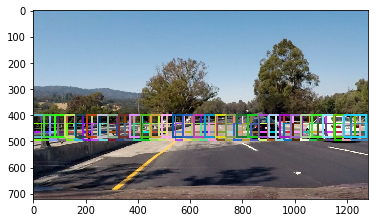

In [57]:
image = mpimg.imread('./test_images/test4.jpg')
y_start_stop_list = [(400, 500), (410, 500), (420, 556), (430, 556), (440, 556), (400, 556), (500, 656)]
xy_base = 64


y_start_stop = y_start_stop_list[0]
scale = 1.0
xy = np.int(xy_base * scale)
xy_window = (xy, xy)
b1 =  slide_window(image, x_start_stop=[None, None], y_start_stop = (400, 500), 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))
# # window_list.append(b1)
y_start_stop = y_start_stop_list[0]
scale = 1.3
xy = np.int(xy_base * scale)
xy_window = (xy, xy)
b2 =  slide_window(image, x_start_stop=[None, None], y_start_stop = (400, 500), 
                    xy_window=xy_window, xy_overlap=(0.5, 0.5))
# window_list.append(b2)

window_list = b1 + b2 
image_box = draw_boxes(image, window_list, color='random', thick=6)
plt.imshow(image_box)

/home/wangmin/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


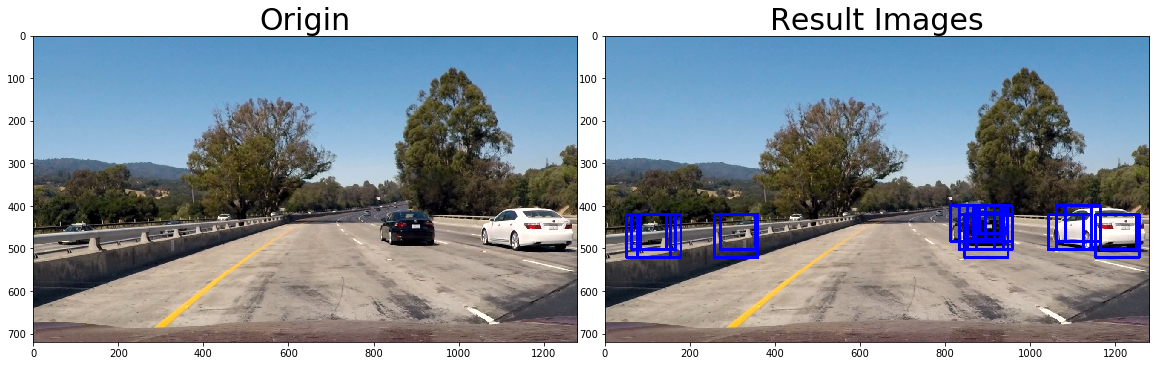

In [17]:
image = mpimg.imread('./test_images/test4.jpg')
bboxes = apply_sliding_window(img, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Origin', fontsize=30)
ax2.imshow(output_image)
ax2.set_title('Result Images', fontsize=30)

/home/wangmin/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


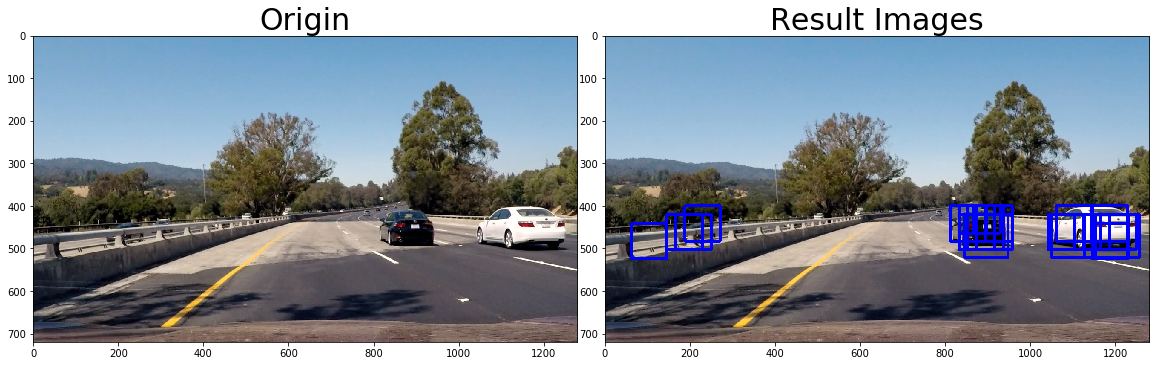

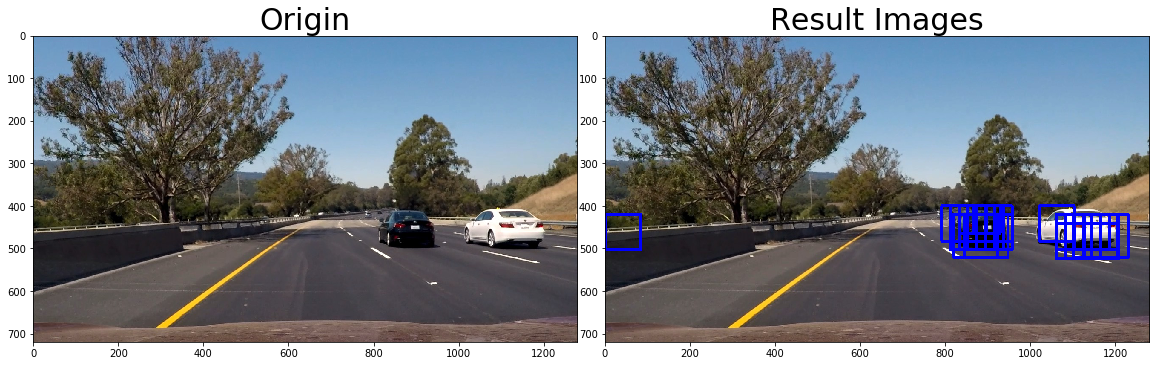

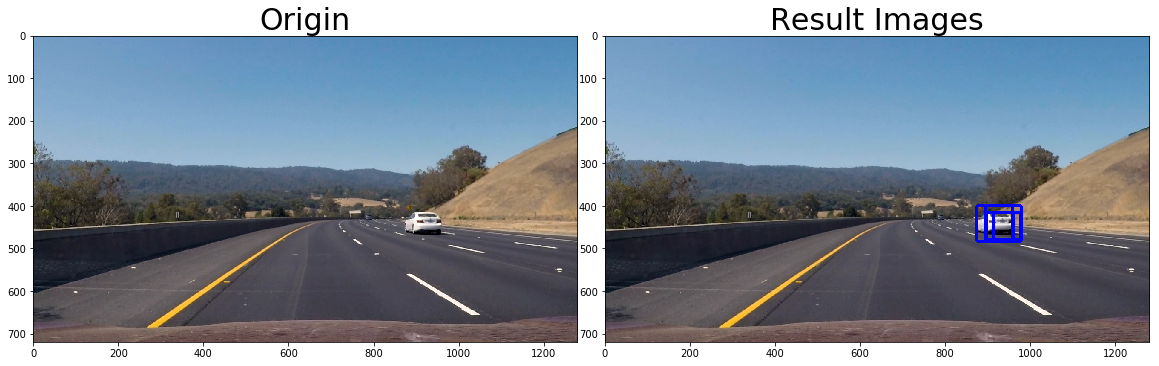

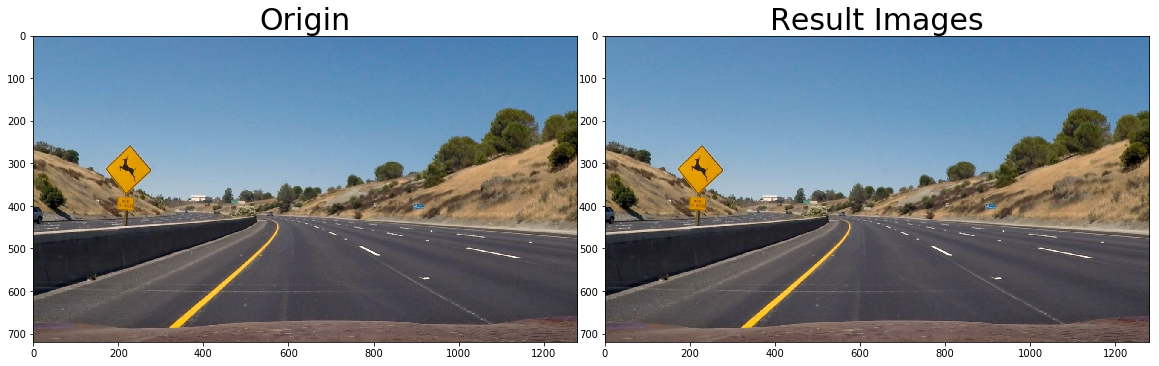

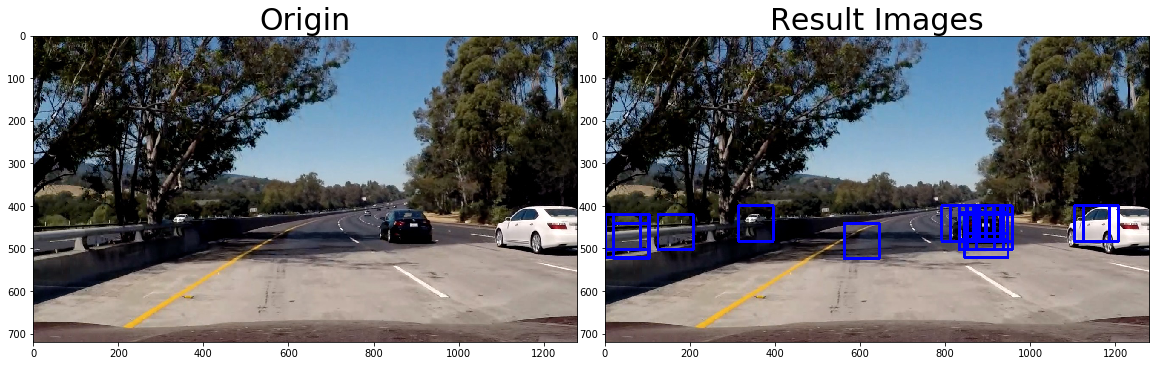

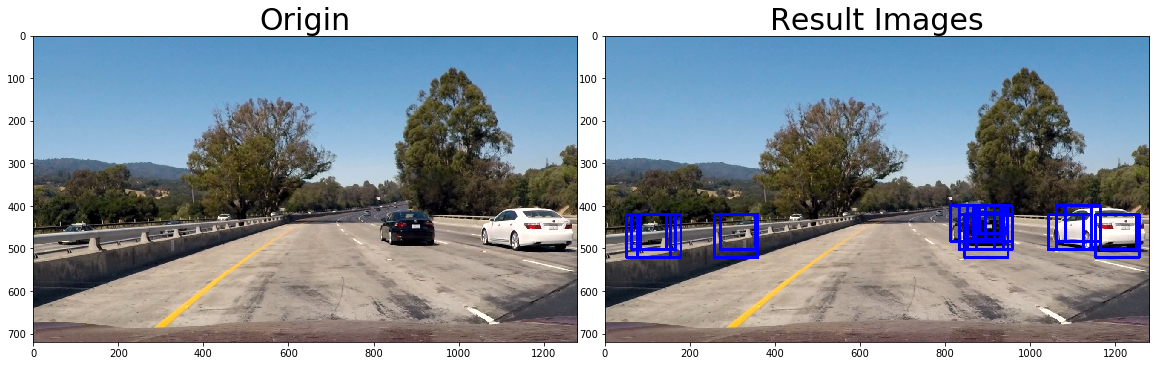

In [11]:
test_image_files = glob.glob('./test_images/test*.jpg')

for img_file in test_image_files:
    img = mpimg.imread(img_file)
    bboxes = apply_sliding_window(img, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    output_image = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
#     plt.imshow(output_image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title('Origin', fontsize=30)
    ax2.imshow(output_image)
    ax2.set_title('Result Images', fontsize=30)

In [12]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [13]:
def get_heatmap(output_image, bboxes):
    threshold = 1
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float) 
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

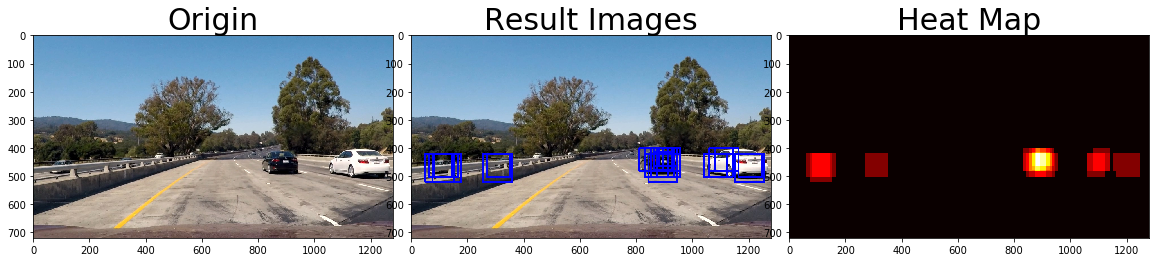

In [18]:
heatmap = get_heatmap(output_image, bboxes)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Origin', fontsize=30)
ax2.imshow(output_image)
ax2.set_title('Result Images', fontsize=30)
ax3.imshow(heatmap, cmap='hot')
ax3.set_title('Heat Map', fontsize=30)

/home/wangmin/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


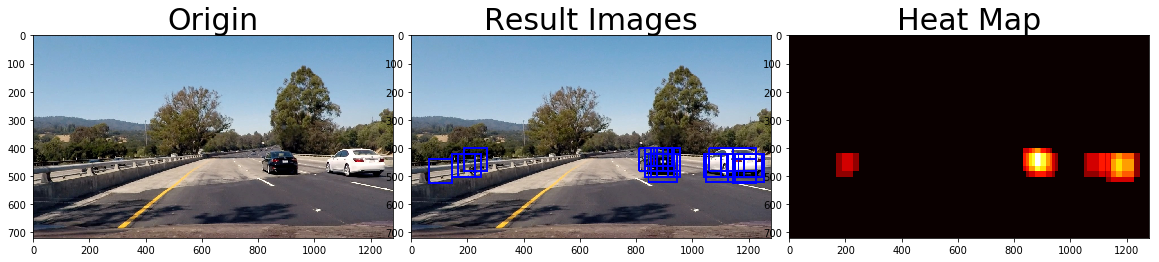

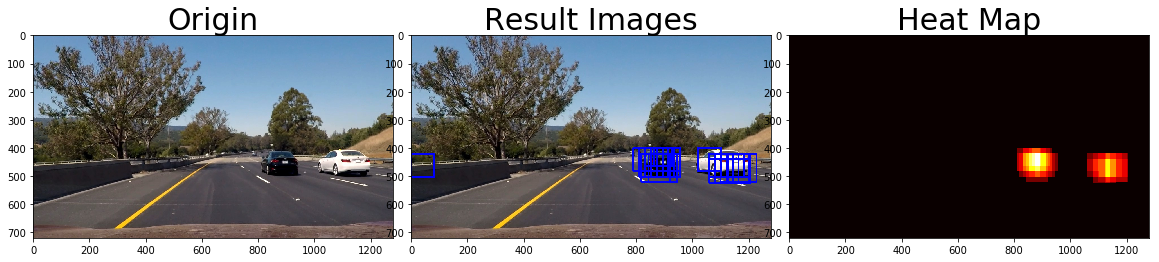

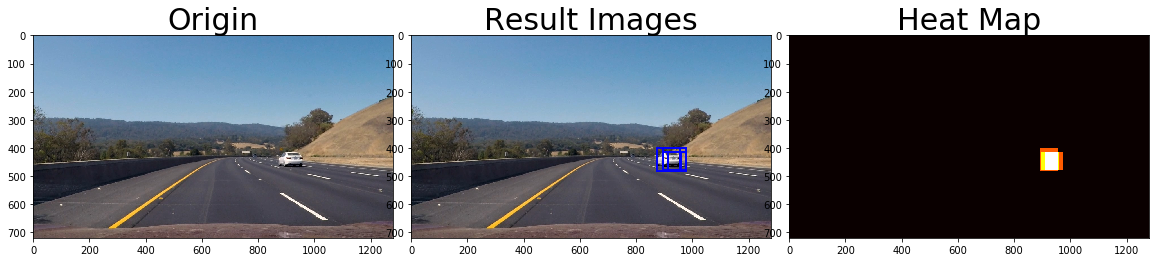

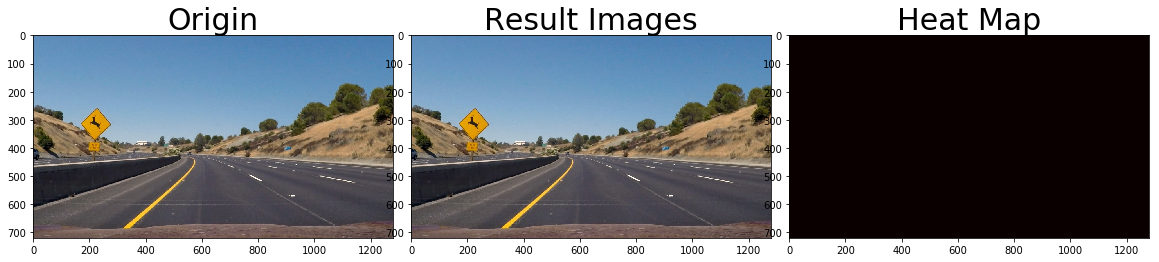

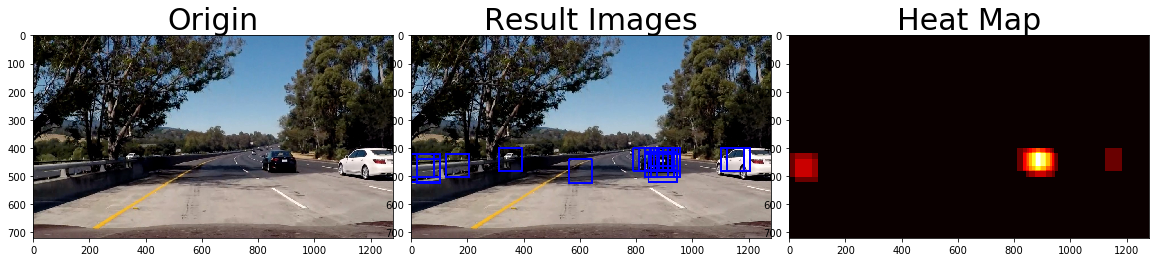

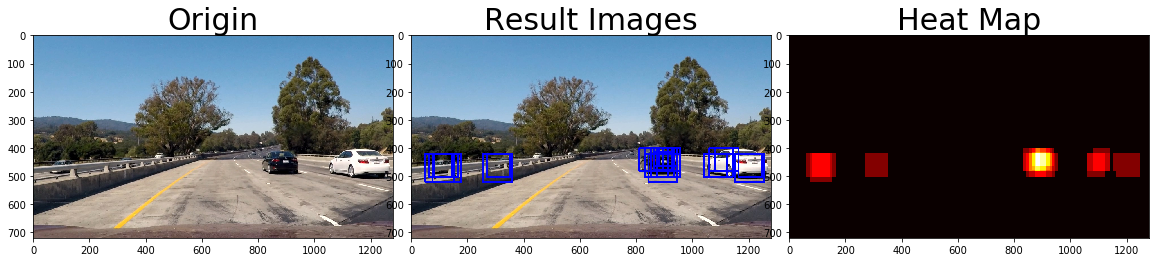

In [14]:
for img_file in test_image_files:
    img = mpimg.imread(img_file)
    bboxes = apply_sliding_window(img, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    output_image = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
       
    heatmap = get_heatmap(output_image, bboxes)
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title('Origin', fontsize=30)
    ax2.imshow(output_image)
    ax2.set_title('Result Images', fontsize=30)
    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title('Heat Map', fontsize=30)


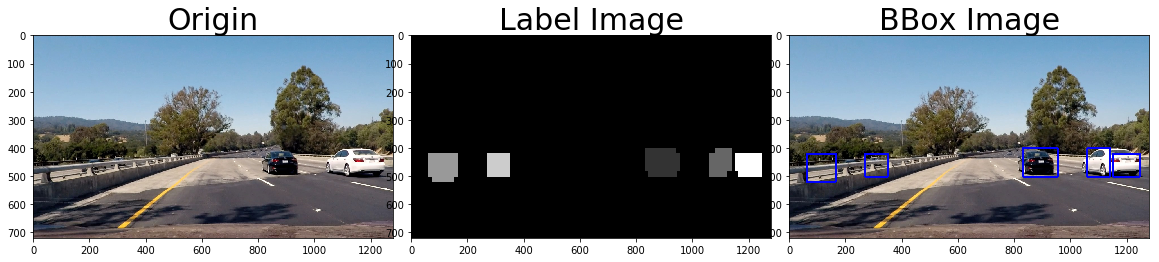

In [26]:
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(image)
ax1.set_title('Origin', fontsize=30)
ax2.imshow(labels[0], cmap = 'gray')
ax2.set_title('Label Image', fontsize=30)
ax3.imshow(draw_img)
ax3.set_title('BBox Image', fontsize=30)

/home/wangmin/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


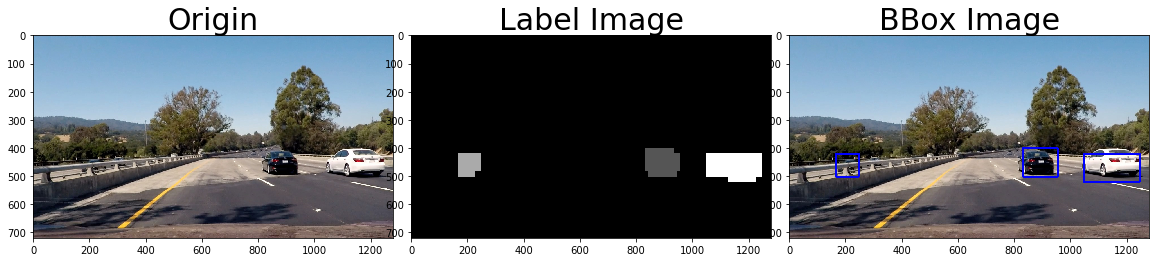

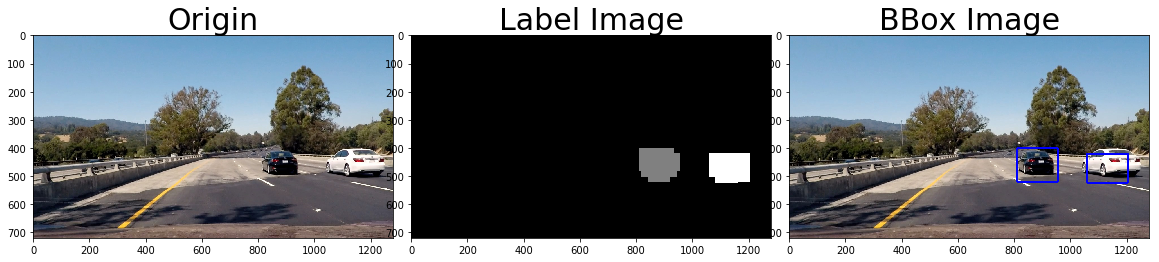

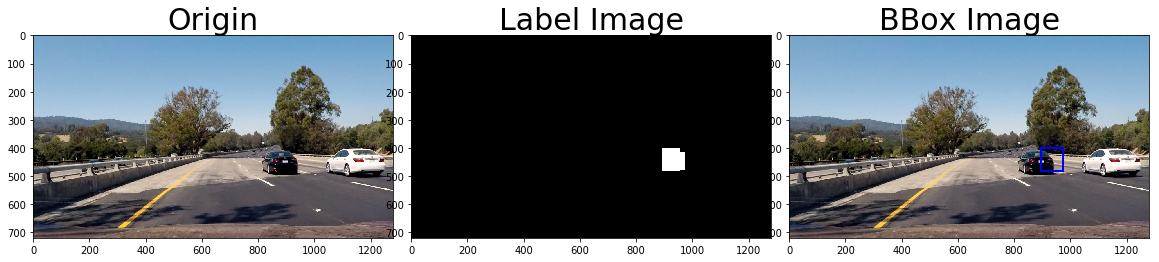

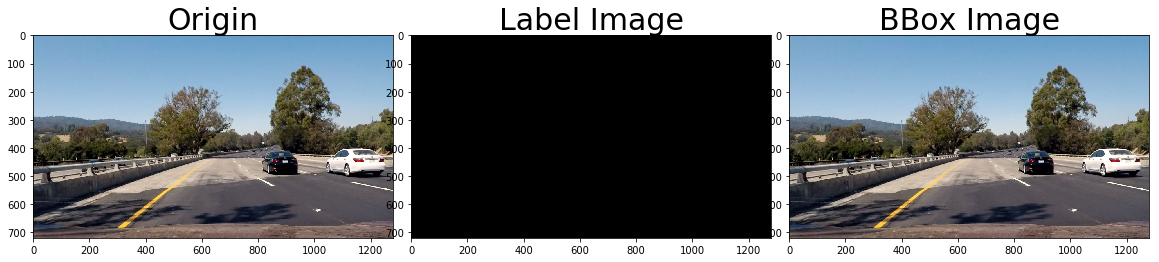

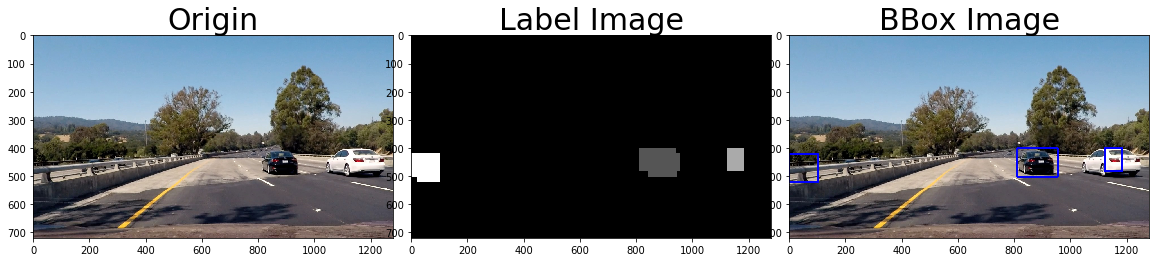

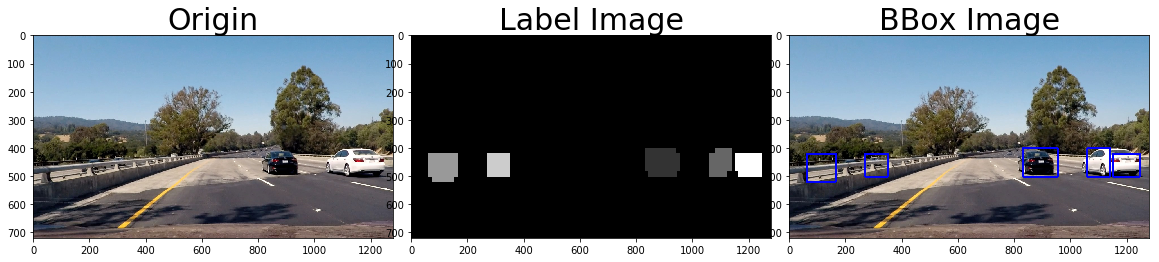

In [28]:
for img_file in test_image_files:
    img = mpimg.imread(img_file)
    bboxes = apply_sliding_window(img, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    output_image = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
       
    heatmap = get_heatmap(output_image, bboxes)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(image)
    ax1.set_title('Origin', fontsize=30)
    ax2.imshow(labels[0], cmap = 'gray')
    ax2.set_title('Label Image', fontsize=30)
    ax3.imshow(draw_img)
    ax3.set_title('BBox Image', fontsize=30)

/home/wangmin/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


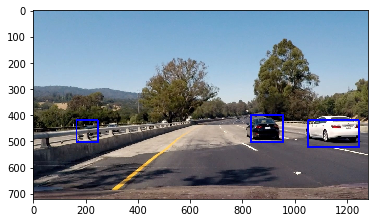

In [29]:
from collections import deque
history = deque(maxlen = 8)

def detect_cars(image):

    bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    out_img = draw_boxes(image, bboxes)
   
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    threshold = 1 
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    
img = detect_cars(image)
plt.imshow(img)

In [30]:
# import imageio
# imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = deque(maxlen = 8)
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|█████████▋| 38/39 [00:25<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

CPU times: user 1min 8s, sys: 253 ms, total: 1min 9s
Wall time: 26.2 s


In [32]:
history = deque(maxlen = 8)
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



 12%|█▏        | 152/1261 [01:44<12:13,  1.51it/s]


 24%|██▍       | 303/1261 [03:27<10:38,  1.50it/s]


 36%|███▌      | 454/1261 [05:08<10:37,  1.27it/s]


 48%|████▊     | 605/1261 [2:34:51<116:23:39, 638.75s/it]


 59%|█████▉    | 750/1261 [2:36:41<05:55,  1.44it/s]


 71%|███████   | 896/1261 [2:38:28<04:04,  1.49it/s]


 83%|████████▎ | 1041/1261 [2:40:09<02:28,  1.48it/s]


 94%|█████████▍| 1184/1261 [2:41:48<00:53,  1.45it/s]


100%|█████████▉| 1260/1261 [2:42:42<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 40min 22s, sys: 5.62 s, total: 40min 28s
Wall time: 2h 42min 42s
